In [1]:
import os
import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.reset_default_graph()

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32
NUM_CLASSES = 2

# data generator

In [3]:
class Barkley_Deep_Drive(object):
    
    def __init__(self, tfrecord_path):
        self.dataset = tf.data.TFRecordDataset(tfrecord_path)
        
    @staticmethod
    def normalize(image, label):
        """Convert `image` from [0, 255] -> [-0.5, 0.5] floats."""
        image = tf.cast(image, tf.float32) * (1. / 255)
        return image, label
        
    @staticmethod
    def decode(serialized_example):
        """
        Parses an image and label from the given `serialized_example`.
        It is used as a map function for `dataset.map`
        """
        IMAGE_SHAPE = (128,128,3)

        # 1. define a parser
        features = tf.parse_single_example(
            serialized_example,
            # Defaults are not specified since both keys are required.
            features={
                'image': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.string),
            })

        # 2. Convert the data
        image = tf.decode_raw(features['image'], tf.float32)
        label = features['label']

        # 3. reshape
        image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))

        return image, label
    
    def get_batch(self, batch_size = 32, shuffle = True, num_threads = -1, buffer_size=4096):
        
        self.dataset = self.dataset.map(self.decode, num_parallel_calls=num_threads)
        
        if shuffle:
            self.dataset = self.dataset.shuffle(buffer_size)
            
        self.dataset = self.dataset.map(self.normalize)
        self.dataset = self.dataset.batch(batch_size)
        
        iterator = self.dataset.make_one_shot_iterator()

        return iterator.get_next()
        

# Network

In [4]:
def discriminator(input_var, name='D_discriminator', reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        # Five intermediate blocks : conv + layer norm + instance norm + leaky relu
        for i in range(num_blocks):
            conv = tf.layers.conv2d(inputs = input_var,
                                    filters = filters, 
                                    kernel_size = kernel_size,
                                    padding = 'valid', 
                                    strides = strides)
            layer_norm = tf.contrib.layers.layer_norm(conv)
            instance_norm = tf.contrib.layers.instance_norm(layer_norm)
            leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)

            input_var = leaky_relu_out
            filters += filters
            
        
        # Output block : fc(1024) + layer norm + instance norm + leaky relu
        output_blocks = input_var
        
        fc = tf.contrib.layers.fully_connected(output_blocks, num_outputs = 1024)
        layer_norm = tf.contrib.layers.layer_norm(fc)
        instance_norm = tf.contrib.layers.instance_norm(layer_norm)
        leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)
        # Output
        output = tf.contrib.layers.fully_connected(leaky_relu_out, num_outputs = 1)
        
        return output

In [5]:
def classifier(input_var, name='C_classifier', reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        # Five intermediate blocks : conv + layer norm + instance norm + leaky relu
        for i in range(num_blocks):
            
            conv = tf.layers.conv2d(inputs = input_var,
                                    filters = filters, 
                                    kernel_size = kernel_size,
                                    padding = 'valid', 
                                    strides = strides)
            layer_norm = tf.contrib.layers.layer_norm(conv)
            instance_norm = tf.contrib.layers.instance_norm(layer_norm)
            leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)

            input_var = leaky_relu_out
            filters += filters

        # Output block : fc(1024) + layer norm + instance norm + leaky relu
        output_blocks = input_var
        fc = tf.contrib.layers.fully_connected(output_blocks, 
                                               num_outputs = 1024)
        layer_norm = tf.contrib.layers.layer_norm(fc)
        instance_norm = tf.contrib.layers.instance_norm(layer_norm)
        leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)

        # Output
        out = tf.contrib.layers.fully_connected(leaky_relu_out,
                                                num_outputs=2)
        
        return tf.nn.sigmoid(out)

In [6]:
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d", padding = 'VALID'):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
        
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding=padding)
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))

        return tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    
def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))


        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        
        return tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())


    
def encoder(inputs, name = 'G_encoder', reuse=tf.AUTO_REUSE, is_training = True):
    """
    encoder function
    :param: inputs
    :param: name
    :return list of layers:
    """

    with tf.variable_scope(name, reuse=reuse):
        
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        
        layers = []
        layers.append(inputs)
        
        for i in range(num_blocks):
            conv = conv2d(inputs, filters, kernel_size, kernel_size, strides, strides, name = str(i+1))
            batch_norm = tf.contrib.layers.batch_norm(conv)
            leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha)
            
            inputs = leaky_relu
            filters += filters
            layers.append(inputs)
            
        return layers
    
def decoder(inputs, label, name = 'G_decoder', reuse=None, is_training = True):
    """
    decoder function
    :param: inputs (list of layers from encoder)
    :param: name
    :return tanh(conv5):
    """
    leakyrelu_alpha = 0.2
    filters = 1024
    kernel_size = 4
    strides = 2
    
    input_ = inputs[-1]

    def _attribute_concat(label, z):
        label = tf.expand_dims(label, 1)
        label = tf.expand_dims(label, 1)
        #label = label[:,tf.newaxis, tf.newaxis,:] #or use expand_dims twice
        label = tf.tile(label, [1, *z.get_shape().as_list()[1:3], 1])
        label = tf.cast(label, dtype=tf.float32)
        label = tf.concat([z, label], axis=3)
        return label
    
    input_ = _attribute_concat(label, input_)
    
    with tf.variable_scope(name, reuse=reuse):
                
        for ind in list(reversed(range(len(inputs)))):
            outout_shape = inputs[ind-1].get_shape().as_list()
            
            if ind==1:
                deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = "deconv_{}".format(ind))
                return tf.nn.tanh(deconv)
            
            deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = str(ind-1))
            concatenated = tf.concat([deconv, inputs[ind-1]], axis=3)

            batch_norm = tf.contrib.layers.batch_norm(concatenated)
            
            input_ = leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha, name = "ReLU_{}".format(ind))

# data input

In [7]:
#TO DO; self._is_eager = tf.executing_eagerly()
#TO DO: allow growth on gpu

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
#tf.enable_eager_execution()
training_data = Barkley_Deep_Drive('../resources/train.tfrecords')
validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')

BATCH_SIZE = 10

image_batch, label_batch = training_data.get_batch(BATCH_SIZE, shuffle = False)
image_batch, label_batch = sess.run([image_batch, label_batch])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


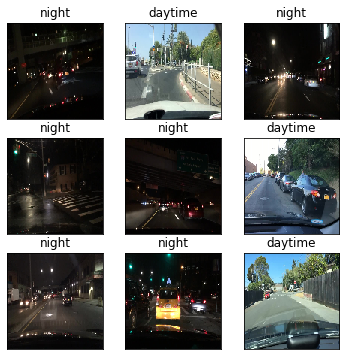

In [9]:
number_of_images = np.int(np.floor(np.sqrt(BATCH_SIZE)))

plt.figure(1, figsize=(number_of_images*2,number_of_images*2))
for ind, i in enumerate(range(number_of_images**2)):
    plt.subplot(number_of_images,number_of_images,i+1)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].decode("utf-8"))

# Loss definitions

<img src="../docs/architecture.png" style="height:500px"> 

In [10]:
xa = tf.placeholder(tf.float32,shape=[BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3],name="xa") #orignal image
z = encoder(xa, reuse=tf.AUTO_REUSE) #encoder output

a = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="a") #original attributes
b = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="b") #desired attributes

xb_hat = decoder(z, b, reuse=tf.AUTO_REUSE) #decoder output
with tf.control_dependencies([xb_hat]):
    xa_hat = decoder(z, a, reuse=tf.AUTO_REUSE) #decoder output

xa_logit_D = discriminator(xa, reuse=tf.AUTO_REUSE) # Discriminator output -- gan
xa_logit_C = classifier(xa, reuse=tf.AUTO_REUSE) # Classifier output -- attribute

xb_logit_D = discriminator(xb_hat, reuse=tf.AUTO_REUSE) # Discriminator output -- gan
xb_logit_C = classifier(xb_hat, reuse=tf.AUTO_REUSE) # Classifier output -- attribute basically b_hat

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
def gradient_penalty(func, a, b):
    """
    :param: discriminator (function)
    :a: xa (tensor)
    :b: xb_hat (tensor)
    :return gp: gradient penalty
    """
    with tf.name_scope('interpolate'):
        alpha = tf.random_uniform(shape=a.shape, minval=0., maxval=1.)
        inter = a + alpha * (b - a)
    with tf.name_scope('gradient_penalty'):
        pred = func(inter, reuse=tf.AUTO_REUSE)
        grad = tf.gradients(pred, inter)[0]
        norm = tf.norm(tf.contrib.slim.flatten(grad), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)
        return gp

# discriminator losses

In [ ]:
lambda_ = {"3" : 1, "2" : 10, "1" : 100}

In [ ]:
#losses
loss_adv_D =  - ( tf.reduce_mean(xa_logit_D) - tf.reduce_mean(xb_logit_D) )

gp = gradient_penalty(discriminator, xa, xb_hat)

loss_cls_C = tf.losses.sigmoid_cross_entropy(tf.reduce_mean(a), tf.reduce_mean(xa_logit_C)) #LOSS ATTRIBUTE
 
D_loss = gp * lambda_['3'] * loss_cls_C + loss_adv_D

# generator lossses

In [ ]:
loss_adv_G = -tf.reduce_mean(xb_logit_D)

loss_cls_G = tf.losses.sigmoid_cross_entropy(tf.reduce_mean(b), tf.reduce_mean(xb_logit_C))

loss_rec = tf.losses.absolute_difference(xa, xa_hat)

G_loss =  lambda_['1'] * loss_rec + lambda_['2'] * loss_cls_G + loss_adv_G